In [1]:
import os
# os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
# import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm
import random

print(tf.__version__)
# print(jax.__version__)

2.16.1


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [5]:
BATCH_SIZE = 4096
DATA_TFREC = "data"
# create list of all tfrec files in folder and sub folders
TFREC_FILES = tf.io.gfile.glob(DATA_TFREC + '/**/*.tfrec')
print(len(TFREC_FILES))
train_files = TFREC_FILES[1:99]
valid_files = TFREC_FILES[99:101]
train_options = tf.data.Options()
train_options.deterministic = True

def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets']


ds = (
    tf.data.TFRecordDataset(TFREC_FILES)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

dst = (
    tf.data.TFRecordDataset(train_files)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

dsv = (
    tf.data.TFRecordDataset(valid_files)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    )

101


In [6]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds.map(lambda x, y: x).take(1000))

2024-06-23 14:31:42.168030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-06-23 14:32:41.937173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

In [9]:
model1 = tf.keras.models.load_model('models/cnn1tf.keras')
model2 = tf.keras.models.load_model('models/cnn4tf.keras')

In [10]:
pt1 = model1.predict(dst, batch_size=BATCH_SIZE) * stdd_y[:,:60] + mean_y[:,:60]
pt2 = model2.predict(dst, batch_size=BATCH_SIZE) * stdd_y[:,360:] + mean_y[:,360:]
pv1 = model1.predict(dsv, batch_size=BATCH_SIZE) * stdd_y[:,:60] + mean_y[:,:60]
pv2 = model2.predict(dsv, batch_size=BATCH_SIZE) * stdd_y[:,360:] + mean_y[:,360:]

2391/2391 ━━━━━━━━━━━━━━━━━━━━ 427s 178ms/step


2024-06-23 14:39:49.261214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 143s 60ms/step


2024-06-23 14:42:13.590962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step
      1/Unknown 0s 69ms/step

2024-06-23 14:42:21.518537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


2024-06-23 14:42:24.559676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# ds_list = []

# # Iterate over the elements in the dataset and extract the values
# for element in ds:
#     x_value, _ = element  # Unpack the tuple (features, targets)
#     ds_list.append(x_value.numpy())

# ds_np = np.concatenate(ds_list, axis=0)

# ds_np_plus_features = np.concatenate([ds_np, p_valid1, p_valid2], axis=1)

In [12]:
# ds_np_plus_features.shape

In [13]:
import tensorflow as tf
import numpy as np

# Assuming p_valid1 and p_valid2 are your NumPy arrays
extra_features_train = np.concatenate([pt1, pt2], axis=1)
extra_features_valid = np.concatenate([pv1, pv2], axis=1)

def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets'][60:240]

def add_extra_features(x, targets, extra_features):
    extra_features = tf.expand_dims(extra_features, axis=0)
    x = tf.expand_dims(x, axis=0)
    x = tf.concat([x, extra_features], axis=1)
    return tf.squeeze(x, axis=0), targets

extra_features_dataset_train = tf.data.Dataset.from_tensor_slices(extra_features_train)
extra_features_dataset_valid = tf.data.Dataset.from_tensor_slices(extra_features_valid)

# Parse the TFRecord dataset
parsed_train_dataset = tf.data.TFRecordDataset(train_files).map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
parsed_valid_dataset = tf.data.TFRecordDataset(valid_files).map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

# Zip the parsed dataset with the extra features dataset
combined_train_dataset = tf.data.Dataset.zip((parsed_train_dataset, extra_features_dataset_train))
combined_valid_dataset = tf.data.Dataset.zip((parsed_valid_dataset, extra_features_dataset_valid))

# Map the add_extra_features function to the combined dataset
combined_train_dataset = combined_train_dataset.map(lambda data, extra: add_extra_features(data[0], data[1], extra))
combined_valid_dataset = combined_valid_dataset.map(lambda data, extra: add_extra_features(data[0], data[1], extra))

# Further processing like batching, shuffling, etc.
ds_train = (
    combined_train_dataset
    .with_options(train_options)
    .shuffle(100)
    .shuffle(4 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    combined_valid_dataset
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


### Model definition & Training

In [14]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(1000))

norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-06-23 14:43:44.105092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-23 14:45:00.955807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
epochs = 12
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [16]:
import keras
import tensorflow as tf

keras.utils.clear_session()

def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:360], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 376:616], (-1, 4, 60)), (0, 2, 1))
    x_flat1 = keras.ops.reshape(x[:, 360:376], (-1, 1, 16))
    x_flat1 = keras.ops.repeat(x_flat1, 60, axis=1)
    x_flat2 = keras.ops.reshape(x[:, 616:], (-1, 1, 8))
    x_flat2 = keras.ops.repeat(x_flat2, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat1, x_flat2], axis=-1)


def build_cnn(activation='relu'):    
    return keras.Sequential([
        keras.layers.Conv1D(512, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(256, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(164, 3, padding='same', activation=activation),
        keras.layers.BatchNormalization(),
    ])


X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:])
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x = x_to_seq(x)


e = e0 = keras.layers.Conv1D(164, 1, padding='same')(x)
e = build_cnn()(e)
# add global average to allow some comunication between all levels even in a small CNN
e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e)


p_seq = keras.layers.Conv1D(3, 1, padding='same')(e)

# p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 180


# build & compile
model = keras.Model(X_input, p_seq)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=[ClippedR2Score()]
)
model.build(tuple(ds_train.element_spec[0].shape))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 624)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 624)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 240)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 8)         │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 8)      │          0 │ get_item_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 4)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_1 (Repeat)   │ (None, 60, 8)     │          0 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 34)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0],     │
│                     │                   │            │ repeat_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 164)   │      5,740 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 164)   │    811,700 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 164)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 164)    │          0 │ sequential[0][0]

 Total params: 1,630,291 (6.22 MB)

 Trainable params: 1,625,723 (6.20 MB)

 Non-trainable params: 4,568 (17.84 KB)

In [17]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [18]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/cnn2_extra.keras'),
        # keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, monitor='val_r2_score', mode='max', min_lr=1e-6)
    ]
)

Epoch 1/12
   2391/Unknown 1798s 750ms/step - loss: 0.5228 - r2_score: 0.1726

2024-06-23 15:14:59.819948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 15:14:59.819974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_8/_92]]
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1810s 755ms/step - loss: 0.5228 - r2_score: 0.1726 - val_loss: 0.3786 - val_r2_score: 0.2743
Epoch 2/12


2024-06-23 15:15:11.659937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 15:15:11.659952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - loss: 0.3639 - r2_score: 0.2891

2024-06-23 15:43:58.675957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 15:43:58.676002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_66/_156]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1738s 727ms/step - loss: 0.3639 - r2_score: 0.2891 - val_loss: 0.3621 - val_r2_score: 0.2930
Epoch 3/12


2024-06-23 15:44:09.233691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 15:44:09.233721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - loss: 0.3426 - r2_score: 0.3122

2024-06-23 16:12:11.883216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 16:12:11.883256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_68/_158]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1693s 708ms/step - loss: 0.3426 - r2_score: 0.3122 - val_loss: 0.3496 - val_r2_score: 0.3067
Epoch 4/12


2024-06-23 16:12:22.541954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 16:12:22.541971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - loss: 0.3339 - r2_score: 0.3223

2024-06-23 16:41:19.710784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 16:41:19.710823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_8/_92]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1749s 731ms/step - loss: 0.3339 - r2_score: 0.3223 - val_loss: 0.3334 - val_r2_score: 0.3241
Epoch 5/12


2024-06-23 16:41:31.437503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 16:41:31.437526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Size/_6]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - loss: 0.3224 - r2_score: 0.3368

2024-06-23 17:11:28.114845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 17:11:28.114924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/IsInf/_224]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1807s 756ms/step - loss: 0.3224 - r2_score: 0.3368 - val_loss: 0.3326 - val_r2_score: 0.3262
Epoch 6/12


2024-06-23 17:11:38.502335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IsInf/_18]]
2024-06-23 17:11:38.502361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - loss: 0.3156 - r2_score: 0.3467

2024-06-23 17:40:05.522804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 17:40:05.522823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_38/_124]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1718s 718ms/step - loss: 0.3156 - r2_score: 0.3467 - val_loss: 0.3277 - val_r2_score: 0.3330
Epoch 7/12


2024-06-23 17:40:16.402238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 17:40:16.402265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - loss: 0.3091 - r2_score: 0.3558

2024-06-23 18:09:11.122723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 18:09:11.122753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/CosineDecay/cond/else/_148/adam/CosineDecay/cond/CosineDecay/Cos/_174]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1746s 730ms/step - loss: 0.3091 - r2_score: 0.3558 - val_loss: 0.3285 - val_r2_score: 0.3321
Epoch 8/12


2024-06-23 18:09:22.174659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 18:09:22.174683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - loss: 0.3039 - r2_score: 0.3623

2024-06-23 18:38:51.535744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 18:38:51.535815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_10/_94]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1781s 745ms/step - loss: 0.3039 - r2_score: 0.3623 - val_loss: 0.3230 - val_r2_score: 0.3390
Epoch 9/12


2024-06-23 18:39:03.173653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 18:39:03.173673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - loss: 0.3001 - r2_score: 0.3669

2024-06-23 19:07:27.800207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 19:07:27.800260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_52/_140]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1715s 717ms/step - loss: 0.3001 - r2_score: 0.3669 - val_loss: 0.3173 - val_r2_score: 0.3449
Epoch 10/12


2024-06-23 19:07:38.329746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 19:07:38.329774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - loss: 0.2969 - r2_score: 0.3721

2024-06-23 19:35:41.498472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 19:35:41.498551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_10/_94]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1694s 708ms/step - loss: 0.2969 - r2_score: 0.3721 - val_loss: 0.3152 - val_r2_score: 0.3476
Epoch 11/12


2024-06-23 19:35:51.954517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]
2024-06-23 19:35:51.954542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - loss: 0.2946 - r2_score: 0.3750

2024-06-23 20:03:55.875549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 20:03:55.875569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/IsInf/_224]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1695s 709ms/step - loss: 0.2946 - r2_score: 0.3750 - val_loss: 0.3134 - val_r2_score: 0.3504
Epoch 12/12


2024-06-23 20:04:06.504645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 20:04:06.504664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - loss: 0.2929 - r2_score: 0.3769

2024-06-23 20:32:43.092178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 20:32:43.092200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_66/_156]]


2391/2391 ━━━━━━━━━━━━━━━━━━━━ 1727s 722ms/step - loss: 0.2929 - r2_score: 0.3769 - val_loss: 0.3118 - val_r2_score: 0.3524


2024-06-23 20:32:53.973667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-23 20:32:53.973689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_8]]


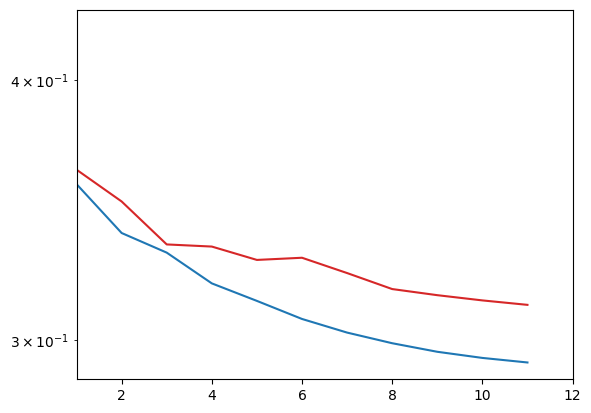

In [19]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.xlim(1, epochs)
plt.yscale('log');

In [20]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-23 20:32:57.669113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step


2024-06-23 20:33:07.707230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
p_valid.numpy()[0]

array([ 8.1199630e-13,  4.3406210e-13, -1.2861710e-12, -2.8698363e-13,
       -6.8581225e-13, -4.1919769e-13, -2.8576376e-13,  6.6340667e-13,
        7.9908552e-13,  1.5034578e-12,  1.2450415e-12, -8.7673500e-14,
        1.0709600e-13,  4.5869021e-13,  2.3388648e-13, -3.7660519e-13,
        7.5562842e-13,  7.9421794e-13, -2.0072464e-12,  1.6583917e-12,
       -8.7709744e-12, -1.7645904e-11, -3.8691387e-11, -7.6504053e-11,
       -4.5332127e-11, -5.4372173e-11, -1.4568613e-10, -3.4096936e-10,
        1.1694157e-10,  2.1390978e-10,  6.8443207e-10,  9.3113872e-10,
        8.2241147e-10, -8.4014795e-10, -1.9140749e-09, -1.2190770e-09,
        1.0598071e-09,  3.5828251e-09, -3.1355123e-09, -1.3475592e-09,
       -2.3606124e-09,  3.6912983e-08, -3.7768295e-09, -2.8436407e-08,
        3.6788457e-08,  4.1249076e-10, -3.2174370e-08,  2.0240464e-08,
       -1.6508782e-08,  2.1076747e-08,  4.5484185e-08,  9.6836764e-08,
        5.4913933e-08,  1.7377580e-08,  9.4773966e-09, -2.4217771e-08,
      

In [22]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:GPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();